In [1]:
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Layer, Dropout
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D

disease types are folder names for importing the data

In [2]:
disease_types = ['Pepper_Bacterial','Pepper_healthy','Potato_Early_blight','Potato_healthy','Potato_Late_blight','Tomato_Bacterial',
                'Tomato_Curl_Virus','Tomato_Early_blight','Tomato_healthy','Tomato_Late_blight','Tomato_Leaf_Mold','Tomato_mosaic',
                'Tomato_Septoria_leaf_spot','Tomato_spider_mite','Tomato_Target_Spot']
data_dir = '/Users/michaellaraglione/Documents/GitHub/Capstone3/PlantVillage/'
train_dir = os.path.join(data_dir)

importing the data and turning it into a pandas dataset. Then, randomizing the dataset.

In [3]:
train_data = []
for diseases, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), diseases, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'Disease_ID','Disease_Type'])
train.head(5)

,File,Disease_ID,Disease_Type
0,Pepper_Bacterial/47fbd17d-c078-4465-8816-c675a...,0,Pepper_Bacterial
1,Pepper_Bacterial/42ef264d-f255-4674-885a-0921a...,0,Pepper_Bacterial
2,Pepper_Bacterial/435993b8-c7f7-47fd-85ad-bdb04...,0,Pepper_Bacterial
3,Pepper_Bacterial/1fca0f2b-857b-4cef-9218-42b1b...,0,Pepper_Bacterial
4,Pepper_Bacterial/9cee73cb-272f-4121-b82d-c8c2b...,0,Pepper_Bacterial


In [4]:
seed = 45
train = train.sample(frac=1, random_state = seed)
train_index = np.arange(len(train)) #to reset the indices
train.head()

,File,Disease_ID,Disease_Type
3046,Potato_Early_blight/acff9d5e-4b38-4817-a239-93...,2,Potato_Early_blight
6803,Tomato_Curl_Virus/31945578-c927-474f-b807-1788...,6,Tomato_Curl_Virus
10112,Tomato_Early_blight/9b0106a7-eb90-4bb2-beec-6c...,7,Tomato_Early_blight
3126,Potato_Early_blight/4849de96-2e26-4c8d-8944-bd...,2,Potato_Early_blight
5008,Tomato_Bacterial/6c300ff6-c94d-4065-8354-73a14...,5,Tomato_Bacterial


I want to save 5 photos for testing at the end, since I don't want to test using an image used in building or validating the model. 

In [5]:
sampleset = train.head(5)
sampleset

,File,Disease_ID,Disease_Type
3046,Potato_Early_blight/acff9d5e-4b38-4817-a239-93...,2,Potato_Early_blight
6803,Tomato_Curl_Virus/31945578-c927-474f-b807-1788...,6,Tomato_Curl_Virus
10112,Tomato_Early_blight/9b0106a7-eb90-4bb2-beec-6c...,7,Tomato_Early_blight
3126,Potato_Early_blight/4849de96-2e26-4c8d-8944-bd...,2,Potato_Early_blight
5008,Tomato_Bacterial/6c300ff6-c94d-4065-8354-73a14...,5,Tomato_Bacterial


In [6]:
train = train.iloc[5:]

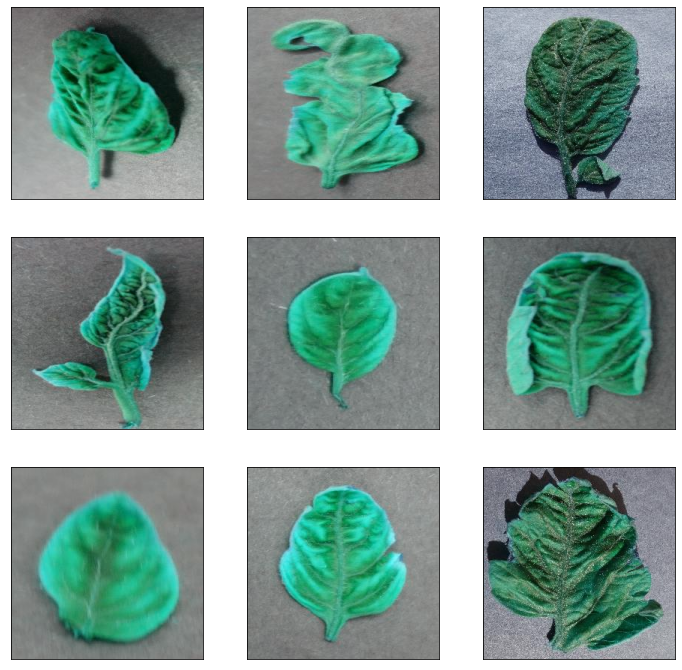

In [7]:
def disease_type(disease_type, rows, cols):
    fig,ax = plt.subplots(rows, cols, figsize=(12,12))
    disease_type = train['File'][train['Disease_Type'] == disease_type].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, disease_type[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
disease_type('Tomato_Curl_Virus', 3, 3)

In [8]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split = 0.2)
validation_generator = datagen.flow_from_directory(
    data_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb",
    class_mode="categorical")

train_generator = datagen.flow_from_directory(
    data_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical")

Found 20638 images belonging to 15 classes.
Found 16516 images belonging to 15 classes.


In [41]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape=(256,256,3)),
    keras.layers.AveragePooling2D(),
    keras.layers.Conv2D(filters=20, kernel_size=(5, 5), activation='relu'),
    keras.layers.AveragePooling2D(),
    keras.layers.Flatten(),
    #keras.layers.Dropout(0.5),
    keras.layers.Dense(units=120, activation='relu'),
    keras.layers.Dense(units=84, activation='relu'),
    keras.layers.Dense(units=15, activation = 'softmax')])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 252, 252, 6)       456       
_________________________________________________________________
average_pooling2d_4 (Average (None, 126, 126, 6)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 122, 122, 20)      3020      
_________________________________________________________________
average_pooling2d_5 (Average (None, 61, 61, 20)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 74420)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 120)               8930520   
_________________________________________________________________
dense_7 (Dense)              (None, 84)               

In [42]:
batch_size = 32
epochs = 15

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(train_generator, batch_size=batch_size, epochs=epochs, validation_data=validation_generator)

Epoch 1/15
517/517 [==============================] - 293s 566ms/step - loss: 1.6323 - accuracy: 0.4856 - val_loss: 0.7461 - val_accuracy: 0.7487
Epoch 2/15
517/517 [==============================] - 293s 566ms/step - loss: 0.5965 - accuracy: 0.8014 - val_loss: 0.3265 - val_accuracy: 0.8973
Epoch 3/15
517/517 [==============================] - 294s 568ms/step - loss: 0.3309 - accuracy: 0.8904 - val_loss: 0.2216 - val_accuracy: 0.9337
Epoch 4/15
517/517 [==============================] - 293s 567ms/step - loss: 0.1824 - accuracy: 0.9398 - val_loss: 0.1856 - val_accuracy: 0.9426
Epoch 5/15
517/517 [==============================] - 293s 567ms/step - loss: 0.1262 - accuracy: 0.9589 - val_loss: 0.1563 - val_accuracy: 0.9535
Epoch 6/15
517/517 [==============================] - 293s 566ms/step - loss: 0.1015 - accuracy: 0.9676 - val_loss: 0.3515 - val_accuracy: 0.8873
Epoch 7/15
517/517 [==============================] - 293s 568ms/step - loss: 0.1075 - accuracy: 0.9643 - val_loss: 0.2399 -

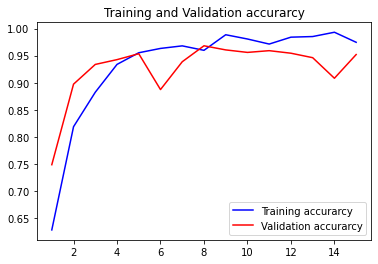

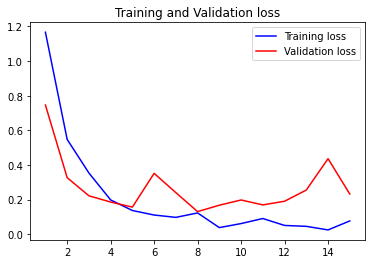

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [44]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [36]:
preds = model.predict_generator(validation_generator, steps=5)
label = validation_generator.classes
pred = model.predict(validation_generator)

predicted_class_indices=np.argmax(pred,axis=1)

/Users/michaellaraglione/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [37]:
labels = (validation_generator.class_indices)
labels2 = dict((v,k) for k,v in labels.items())
predictions = [labels2[k] for k in predicted_class_indices]


In [45]:
sampleset

,File,Disease_ID,Disease_Type
3046,Potato_Early_blight/acff9d5e-4b38-4817-a239-93...,2,Potato_Early_blight
6803,Tomato_Curl_Virus/31945578-c927-474f-b807-1788...,6,Tomato_Curl_Virus
10112,Tomato_Early_blight/9b0106a7-eb90-4bb2-beec-6c...,7,Tomato_Early_blight
3126,Potato_Early_blight/4849de96-2e26-4c8d-8944-bd...,2,Potato_Early_blight
5008,Tomato_Bacterial/6c300ff6-c94d-4065-8354-73a14...,5,Tomato_Bacterial


In [46]:
sample1 = data_dir + sampleset['File'].iloc[0]
sample2 = data_dir + sampleset['File'].iloc[1]
sample3 = data_dir + sampleset['File'].iloc[2]
sample4 = data_dir + sampleset['File'].iloc[3]
sample5 = data_dir + sampleset['File'].iloc[4]

In [38]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

cf_report = classification_report(predicted_class_indices,label)
cm = confusion_matrix(predicted_class_indices,label)

print(cf_report)


              precision    recall  f1-score   support

           0       0.93      0.94      0.94       986
           1       0.95      0.98      0.97      1440
           2       0.98      0.96      0.97      1021
           3       0.95      0.94      0.95      1017
           4       0.90      0.91      0.90       151
           5       0.97      0.97      0.97      2125
           6       0.99      0.98      0.98      3227
           7       0.75      0.97      0.85       773
           8       0.95      0.94      0.95      1928
           9       0.93      0.97      0.95       920
          10       0.92      0.93      0.92      1760
          11       0.94      0.84      0.89      1561
          12       1.00      0.95      0.97      1671
          13       0.90      0.99      0.94       340
          14       0.97      0.94      0.95      1718

    accuracy                           0.95     20638
   macro avg       0.94      0.95      0.94     20638
weighted avg       0.95   

Text(0.5, 185.99374999999995, 'Predicted')

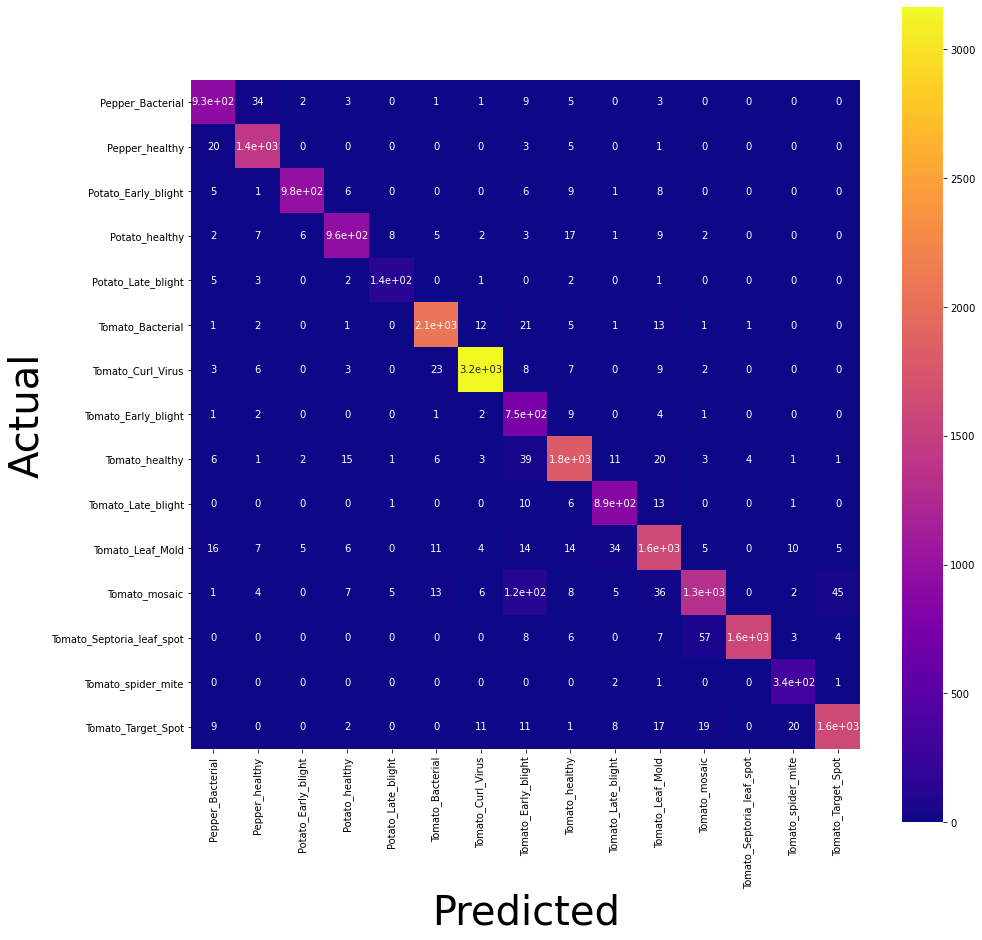

In [39]:
plt.figure(figsize=(15,15))
ax = sns.heatmap(cm, cmap=plt.cm.plasma, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)

ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

In [47]:
image = tf.keras.preprocessing.image.load_img(sample1)
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])
preds1 = model.predict_classes(input_arr)

image = tf.keras.preprocessing.image.load_img(sample2)
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])
preds2 = model.predict_classes(input_arr)

image = tf.keras.preprocessing.image.load_img(sample3)
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])
preds3 = model.predict_classes(input_arr)

image = tf.keras.preprocessing.image.load_img(sample4)
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])
preds4 = model.predict_classes(input_arr)

image = tf.keras.preprocessing.image.load_img(sample5)
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])
preds5 = model.predict_classes(input_arr)

/Users/michaellaraglione/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [48]:
print(preds1, preds2, preds3, preds4, preds5)

[2] [6] [10] [2] [10]


In [49]:
print(disease_types[2],disease_types[6], disease_types[10],disease_types[2],disease_types[10])

Potato_Early_blight Tomato_Curl_Virus Tomato_Leaf_Mold Potato_Early_blight Tomato_Leaf_Mold


In [35]:
sampleset

,File,Disease_ID,Disease_Type
3046,Potato_Early_blight/acff9d5e-4b38-4817-a239-93...,2,Potato_Early_blight
6803,Tomato_Curl_Virus/31945578-c927-474f-b807-1788...,6,Tomato_Curl_Virus
10112,Tomato_Early_blight/9b0106a7-eb90-4bb2-beec-6c...,7,Tomato_Early_blight
3126,Potato_Early_blight/4849de96-2e26-4c8d-8944-bd...,2,Potato_Early_blight
5008,Tomato_Bacterial/6c300ff6-c94d-4065-8354-73a14...,5,Tomato_Bacterial
